In [30]:
import spot
import buddy
import copy
from spot.jupyter import display_inline, display
from IPython.core.display import HTML
spot.setup(show_default='.a')

In [31]:
print('Spot version ', spot.version())

Spot version  2.11.4


In [32]:
# LTL2DBA09
formula = "((((G (F (p))) || (G (F (q)))) || (G (F (r)))) <-> (G (F (acc))))"
inputs = ["r","q","p"]
outputs = ["acc"]

# Automaton Construction

In [33]:
f = spot.formula(formula); nba = f.translate('buchi', 'state-based')
display_inline(nba)

# Synthesis the Formula

game has 10 states and 19 edges
output propositions are: acc


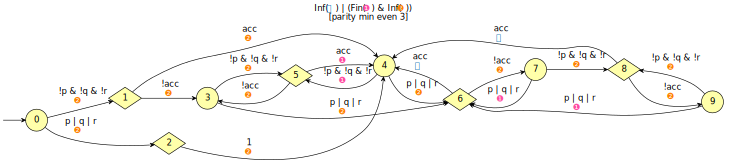

In [34]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_SPLIT_DET

game = spot.ltl_to_game(formula, outputs, si)
print("game has", game.num_states(), "states and", game.num_edges(), "edges")
print("output propositions are:", ", ".join(spot.get_synthesis_output_aps(game)))
display(game)

Found a solution: True


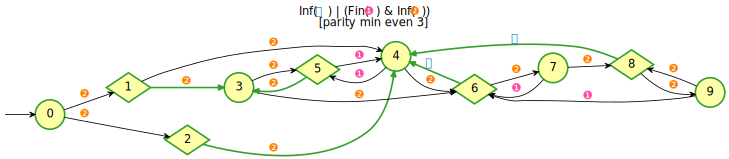

In [35]:
print("Found a solution:", spot.solve_game(game, si))
spot.highlight_strategy(game)
game.show('.g')

### Strategy Mealy Machine

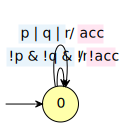

In [36]:
mealy = spot.solved_game_to_mealy(game, si)
spot.simplify_mealy_here(mealy, si.minimize_lvl, False)
display(mealy)

# Handle Unates

In [37]:
# Reconstruct formula and automaton
f = spot.formula(formula); nba = f.translate('buchi', 'state-based')

In [38]:
def handle_unates(nba):
    for state in range(nba.num_states()):
        for var in outputs:
            varnum = nba.register_ap(var)
            
            ############### Check If Var Is Unate ###############
            positive_unate_sufficient_condition = buddy.bddtrue
            negative_unate_sufficient_condition = buddy.bddtrue
            
            for edge in nba.out(state):
                edge_restrict_positive = buddy.bdd_restrict( edge.cond, buddy.bdd_ithvar(varnum) ) 
                edge_restrict_negative = buddy.bdd_restrict( edge.cond, buddy.bdd_nithvar(varnum) )

                positive_unate_sufficient_condition &= buddy.bdd_imp( edge_restrict_negative, edge_restrict_positive )
                negative_unate_sufficient_condition &= buddy.bdd_imp( edge_restrict_positive, edge_restrict_negative )
            
            ########################## Handle Unateness ################
            if positive_unate_sufficient_condition == buddy.bddtrue:
                print(" => POSITIVE UNATE! State {} , Var {}".format(state, var))
                for edge in nba.out(state):
                    edge.cond = buddy.bdd_restrict( edge.cond, buddy.bdd_ithvar(varnum) ) & buddy.bdd_ithvar(varnum)
            elif negative_unate_sufficient_condition == buddy.bddtrue:
                print(" => NEGATIVE UNATE! State {} , Var {}".format(state, var))
                for edge in nba.out(state):
                    edge.cond = buddy.bdd_restrict( edge.cond, buddy.bdd_nithvar(varnum) ) & buddy.bdd_nithvar(varnum)
            else:
                print(" => UNKNOWN UNATE! State {} , Var {}".format(state, var))


In [39]:
handle_unates(nba)
display_inline(nba)

 => UNKNOWN UNATE! State 0 , Var acc
 => UNKNOWN UNATE! State 1 , Var acc
 => NEGATIVE UNATE! State 2 , Var acc
 => UNKNOWN UNATE! State 3 , Var acc
 => UNKNOWN UNATE! State 4 , Var acc


# Tool Automaton

In [75]:
tool_nba_HOA = """
HOA: v1
States: 5
Start: 0
AP: 4 "acc" "p" "q" "r"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc stutter-invariant
--BODY--
State: 0
[t] 0
[t] 1
[!0&!1&!2&!3] 2
State: 1 {0}
[0&1 | 0&2 | 0&3] 1
[!1&!2&!3] 3
[!0&1 | !0&2 | !0&3] 4
State: 2 {0}
[!0&!1&!2&!3] 2
State: 3
[0&1 | 0&2 | 0&3] 1
[!1&!2&!3] 3
[!0&1 | !0&2 | !0&3] 4
State: 4
[0] 1
[!0] 4
--END--
"""

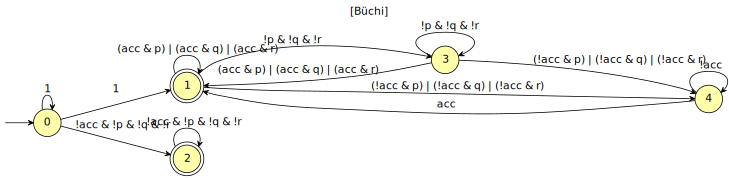

In [76]:
tool_nba = spot.automaton(tool_nba_HOA)
display(tool_nba)

 => NEGATIVE UNATE! State 0 , Var acc
 => UNKNOWN UNATE! State 1 , Var acc
 => NEGATIVE UNATE! State 2 , Var acc
 => UNKNOWN UNATE! State 3 , Var acc
 => UNKNOWN UNATE! State 4 , Var acc


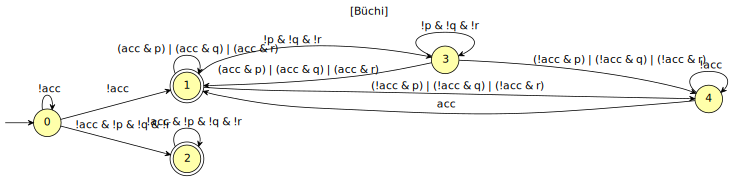

In [42]:
handle_unates(tool_nba)
display(tool_nba)

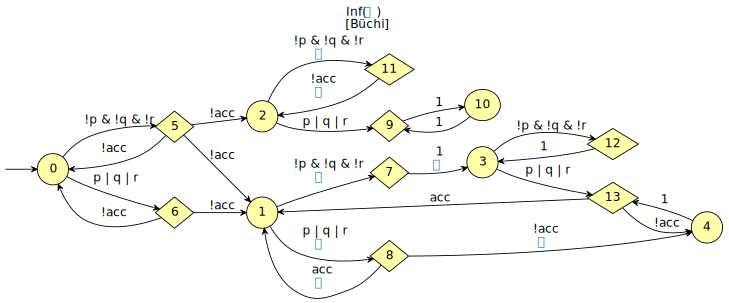

In [43]:
# def nba_to_parity_game(nba):
outs = buddy.bddtrue
for var in outputs:
    varnum = nba.register_ap(var)
    outs &= buddy.bdd_ithvar(varnum)

tool_nba_splitted = spot.split_2step(tool_nba, outs, True)
tool_nba_splitted

Synthesis output vars:


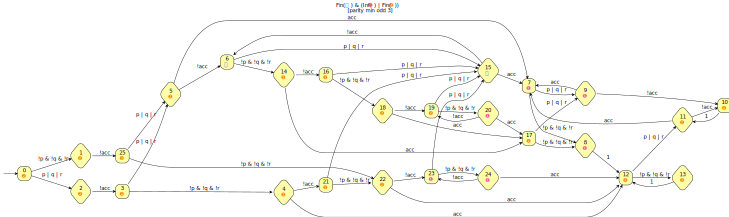

In [44]:
dpa = spot.tgba_determinize(spot.degeneralize_tba(tool_nba_splitted), True, True, True, False)
dpa.merge_states()
dpa = spot.sbacc(dpa)
spot.reduce_parity_here(dpa, True)   # Reduce the parity game to minimal number of colors
spot.alternate_players(dpa)     # Transform an automaton into a parity game by propagating players.
dpa.merge_states()
spot.set_synthesis_outputs(dpa, outs)
print("Synthesis output vars:")
spot.get_synthesis_output_aps(dpa)
dpa

Found a solution: False


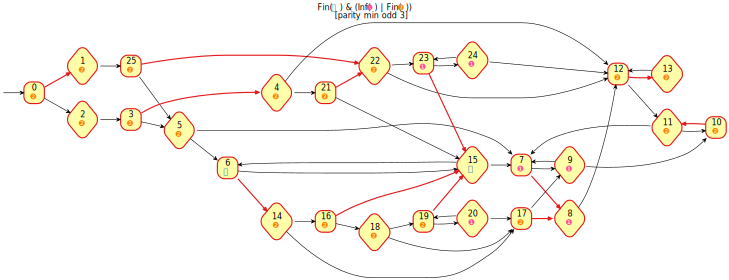

In [45]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_SPLIT_DET
print("Found a solution:", spot.solve_game(dpa, si))
spot.highlight_strategy(dpa)
dpa.show('.g')

In [46]:
print(dpa.to_str('hoa'))

HOA: v1
States: 26
Start: 0
AP: 4 "acc" "p" "q" "r"
acc-name: parity min odd 3
Acceptance: 3 Fin(0) & (Inf(1) | Fin(2))
properties: trans-labels explicit-labels state-acc colored
properties: deterministic
spot-state-player: 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0
controllable-AP: 0
--BODY--
State: 0 {2}
[!1&!2&!3] 1
[1 | 2 | 3] 2
State: 1 {2}
[!0] 25
State: 2 {2}
[!0] 3
State: 3 {2}
[!1&!2&!3] 4
[1 | 2 | 3] 5
State: 4 {2}
[!0] 21
[0] 12
State: 5 {2}
[!0] 6
[0] 7
State: 6 {0}
[!1&!2&!3] 14
[1 | 2 | 3] 15
State: 7 {1}
[!1&!2&!3] 8
[1 | 2 | 3] 9
State: 8 {1}
[t] 12
State: 9 {1}
[!0] 10
[0] 7
State: 10 {2}
[t] 11
State: 11 {2}
[!0] 10
[0] 7
State: 12 {2}
[!1&!2&!3] 13
[1 | 2 | 3] 11
State: 13 {2}
[t] 12
State: 14 {2}
[!0] 16
[0] 17
State: 15 {0}
[!0] 6
[0] 7
State: 16 {2}
[!1&!2&!3] 18
[1 | 2 | 3] 15
State: 17 {2}
[!1&!2&!3] 8
[1 | 2 | 3] 9
State: 18 {2}
[!0] 19
[0] 17
State: 19 {2}
[!1&!2&!3] 20
[1 | 2 | 3] 15
State: 20 {1}
[!0] 19
[0] 17
State: 21 {2}
[!1&!2&!3] 22
[1 | 2 | 3

## Solve Game from C++ Code

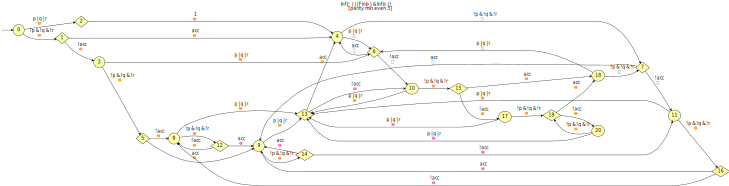

In [74]:
dpa = spot.automaton("""
HOA: v1
States: 21
Start: 0
AP: 4 "acc" "p" "q" "r"
acc-name: parity min even 3
Acceptance: 3 Inf(0) | (Fin(1) & Inf(2))
properties: trans-labels explicit-labels trans-acc colored complete
properties: deterministic
spot-state-player: 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0
controllable-AP: 0
--BODY--
State: 0
[!1&!2&!3] 1 {2}
[1 | 2 | 3] 2 {2}
State: 1
[!0] 3 {2}
[0] 4 {2}
State: 2
[t] 4 {2}
State: 3
[!1&!2&!3] 5 {2}
[1 | 2 | 3] 6 {2}
State: 4
[!1&!2&!3] 7 {0}
[1 | 2 | 3] 6 {0}
State: 5
[!0] 8 {2}
[0] 9 {2}
State: 6
[!0] 10 {0}
[0] 4 {0}
State: 7
[!0] 11 {0}
[0] 9 {0}
State: 8
[!1&!2&!3] 12 {2}
[1 | 2 | 3] 13 {2}
State: 9
[!1&!2&!3] 14 {2}
[1 | 2 | 3] 13 {2}
State: 10
[!1&!2&!3] 15 {2}
[1 | 2 | 3] 13 {2}
State: 11
[!1&!2&!3] 16 {2}
[1 | 2 | 3] 13 {2}
State: 12
[0] 9 {1}
[!0] 8 {2}
State: 13
[!0] 10 {1}
[0] 4 {2}
State: 14
[!0] 11 {1}
[0] 9 {1}
State: 15
[!0] 17 {2}
[0] 18 {2}
State: 16
[!0] 8 {1}
[0] 9 {1}
State: 17
[1 | 2 | 3] 13 {1}
[!1&!2&!3] 19 {2}
State: 18
[!1&!2&!3] 7 {0}
[1 | 2 | 3] 6 {0}
State: 19
[!0] 20 {2}
[0] 18 {2}
State: 20
[1 | 2 | 3] 13 {1}
[!1&!2&!3] 19 {2}
--END--
""")
dpa

In [48]:
spot.set_synthesis_outputs(dpa, outs)
spot.get_synthesis_output_aps(dpa)

('acc',)

Found a solution: True


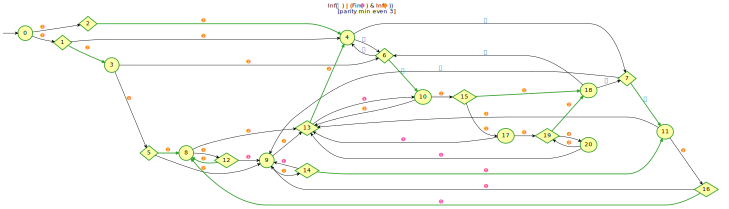

In [49]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_SPLIT_DET
print("Found a solution:", spot.solve_game(dpa, si))
spot.highlight_strategy(dpa)
dpa.show('.g')

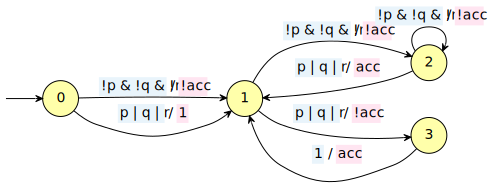

In [50]:
before_unate_strategy = """
HOA: v1
States: 4
Start: 0
AP: 4 "acc" "p" "q" "r"
acc-name: all
Acceptance: 0 t
properties: trans-labels explicit-labels state-acc deterministic
controllable-AP: 0
--BODY--
State: 0
[!0&!1&!2&!3] 1
[1 | 2 | 3] 1
State: 1
[!0&!1&!2&!3] 2
[!0&1 | !0&2 | !0&3] 3
State: 2
[!0&!1&!2&!3] 2
[0&1 | 0&2 | 0&3] 1
State: 3
[0] 1
--END--
"""
display(spot.automaton(before_unate_strategy))

# NBA After Unate

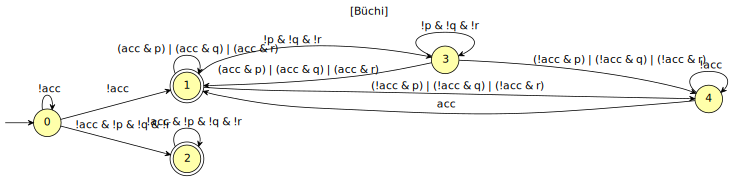

In [51]:
nba_after_unate = spot.automaton("""
HOA: v1
States: 5
Start: 0
AP: 4 "acc" "p" "q" "r"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc stutter-invariant
--BODY--
State: 0
[!0] 0
[!0] 1
[!0&!1&!2&!3] 2
State: 1 {0}
[0&1 | 0&2 | 0&3] 1
[!1&!2&!3] 3
[!0&1 | !0&2 | !0&3] 4
State: 2 {0}
[!0&!1&!2&!3] 2
State: 3
[0&1 | 0&2 | 0&3] 1
[!1&!2&!3] 3
[!0&1 | !0&2 | !0&3] 4
State: 4
[0] 1
[!0] 4
--END--
""")
display(nba_after_unate)

# Synthesis NBA Smaller

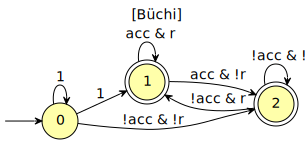

In [67]:
# nba_smaller_HOA = """
# HOA: v1
# States: 3
# Start: 0
# AP: 4 "acc" "p" "q" "r"
# acc-name: Buchi
# Acceptance: 1 Inf(0)
# properties: trans-labels explicit-labels state-acc stutter-invariant
# --BODY--
# State: 0
# [t] 0
# [t] 1
# [!0&!1&!2&!3] 2
# State: 1 {0}
# [0&1 | 0&2 | 0&3] 1
# /* New State */
# [!1&!2&!3] 1
# [!0&1 | !0&2 | !0&3] 1
# /* Preview State: */
# /*
# [!1&!2&!3] 3
# [!0&1 | !0&2 | !0&3] 4
# */
# State: 2 {0}
# [!0&!1&!2&!3] 2
# --END--
# """
nba_smaller_HOA = """
HOA: v1
States: 3
Start: 0
AP: 2 "acc" "r"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc stutter-invariant
--BODY--
State: 0
[t] 0
[t] 1
[!0&!1] 2
State: 1 {0}
[0&1] 1
[0&!1] 2
State: 2 {0}
[!0&!1] 2
[!0&1] 1
--END--
"""
nba_smaller = spot.automaton(nba_smaller_HOA)
nba_smaller

 => NEGATIVE UNATE! State 0 , Var acc
 => POSITIVE UNATE! State 1 , Var acc
 => NEGATIVE UNATE! State 2 , Var acc


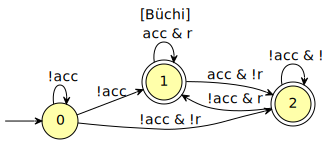

In [68]:
handle_unates(nba_smaller)
display(nba_smaller)

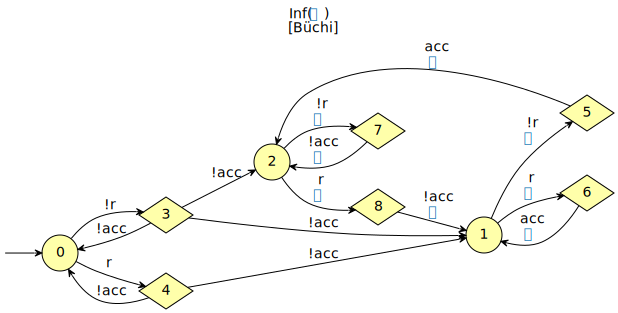

In [69]:
outs = buddy.bddtrue
for var in ["acc"]:
    varnum = nba_smaller.register_ap(var)
    outs &= buddy.bdd_ithvar(varnum)

nba_smaller_splitted = spot.split_2step(nba_smaller, outs, True)
nba_smaller_splitted

In [70]:
dpa_smaller = spot.tgba_determinize(spot.degeneralize_tba(nba_smaller_splitted), True, True, True, False)
dpa_smaller.merge_states()
dpa_smaller = spot.sbacc(dpa_smaller)
spot.reduce_parity_here(dpa_smaller, True)   # Reduce the parity game to minimal number of colors
spot.alternate_players(dpa_smaller)     # Transform an automaton into a parity game by propagating players.
dpa_smaller.merge_states()
spot.set_synthesis_outputs(dpa_smaller, outs)
print("Synthesis output vars:")
spot.get_synthesis_output_aps(dpa_smaller)

Synthesis output vars:


('acc',)

In [71]:
display_inline(dpa_smaller)

Found a solution: True


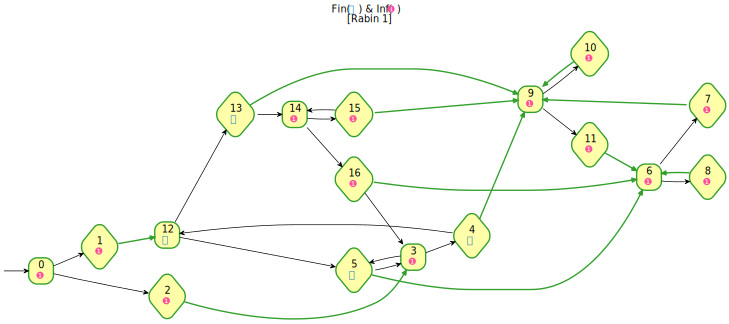

In [73]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_SPLIT_DET
print("Found a solution:", spot.solve_game(dpa_smaller, si))
spot.highlight_strategy(dpa_smaller)
dpa_smaller.show('.g')